In [1]:
"""
Topic: Model Agnostic Meta Learning
Paper Link : https://arxiv.org/abs/1703.03400

This notebook contains an initial implementation of MAML along with some data visualisation
"""

'\nTopic: Model Agnostic Meta Learning\nPaper Link : https://arxiv.org/abs/1703.03400\n\nThis notebook contains an initial implementation of MAML along with some data visualisation\n'

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
#Open source specific imports
import os 
import json
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.models as models

from pathlib import Path
from typing import *
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader
from types import SimpleNamespace

#Local code specific imports
from utils import *
from configs import *
from dataset.datasets import MiniImageNetDataset
from engine.trainer import do_train
from engine.optimizers import AdamExplicitGrad

/anaconda/envs/maml/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#Read config dictionary for this experiment

config = ExperimentConfig()



In [6]:
#Setting seeds for reproducability
torch.manual_seed(config.seed)
np.random.seed(config.seed)
random.seed(config.seed)

In [7]:
#Global Variables
os.environ['TORCH_HOME'] = config.model.torch_home

#Imagenet mean and var to normalise the input images
ImageNetMean, ImageNetVariance = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

#Human readable class mapping of ImageNet classes
class_map = pd.read_csv(config.dataset.classmap_path, header = None, delimiter=" ")
class_map = dict(zip(class_map[0],class_map[1]))

In [8]:
train_classes = os.listdir(config.dataset.train_path)
test_classes = os.listdir(config.dataset.test_path)
val_classes = os.listdir(config.dataset.val_path)

print(config)

ExperimentConfig(dataset=namespace(classmap_path='/home/azureuser/cloudfiles/code/Users/asahu.cool/Work/Datasets/MiniImageNet/classmap.csv', root_path='/home/azureuser/cloudfiles/code/Users/asahu.cool/Work/Datasets/MiniImageNet/mini_imagenet_full_size', test_path='/home/azureuser/cloudfiles/code/Users/asahu.cool/Work/Datasets/MiniImageNet/mini_imagenet_full_size/test', train_path='/home/azureuser/cloudfiles/code/Users/asahu.cool/Work/Datasets/MiniImageNet/mini_imagenet_full_size/train', val_path='/home/azureuser/cloudfiles/code/Users/asahu.cool/Work/Datasets/MiniImageNet/mini_imagenet_full_size/val'), model=namespace(torch_home='/home/azureuser/cloudfiles/code/Users/asahu.cool/Work/Models'), seed=0, training=namespace(K_shot=5, N_way=5, batch_size=16, gpu=True, image_size=(128, 128), inner_loop_steps=4, lr=0.01, n_epochs=1, query_samples_per_class=2))


Text(0, 0.5, 'No of Images')

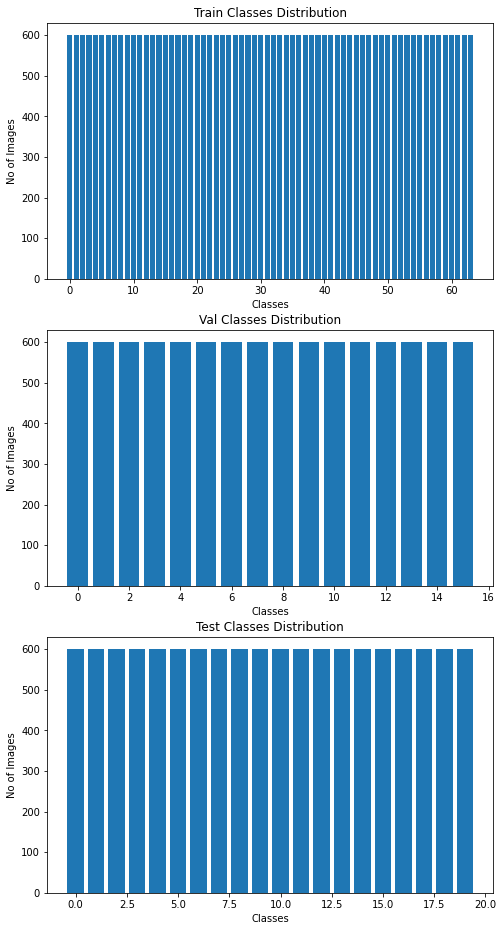

In [9]:
#Plotting Data Distributions for Train, Test and Val

train_class_distrib = class_distribution(config.dataset.train_path,train_classes)
val_class_distrib = class_distribution(config.dataset.val_path,val_classes)
test_class_distrib = class_distribution(config.dataset.test_path,test_classes)

fig = plt.figure(figsize=(8,16))

fig.add_subplot(3,1,1)
plt.bar(list(range(len(train_class_distrib.keys()))), train_class_distrib.values())
plt.title("Train Classes Distribution")
plt.xlabel("Classes")
plt.ylabel("No of Images")


fig.add_subplot(3,1,2)
plt.bar(list(range(len(val_class_distrib.keys()))), val_class_distrib.values())
plt.title("Val Classes Distribution")
plt.xlabel("Classes")
plt.ylabel("No of Images")

fig.add_subplot(3,1,3)
plt.bar(list(range(len(test_class_distrib.keys()))), test_class_distrib.values())
plt.title("Test Classes Distribution")
plt.xlabel("Classes")
plt.ylabel("No of Images")


In [10]:
train_imgs = sample_imgs(config.dataset.train_path,train_classes,0.1,2)

Image of class type: slot


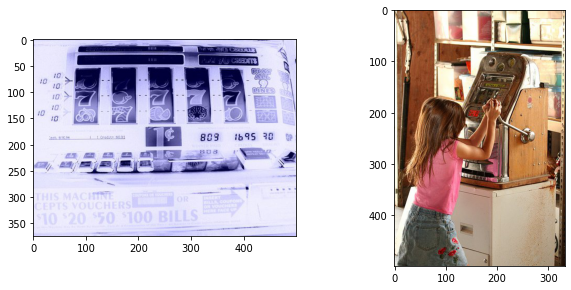

In [11]:
print(f"Image of class type: {class_map[list(train_imgs.keys())[0]]}")
plot_images_grid(3,3,list(train_imgs.values())[0],figsize=(16,16))

Image of class type: spider_web


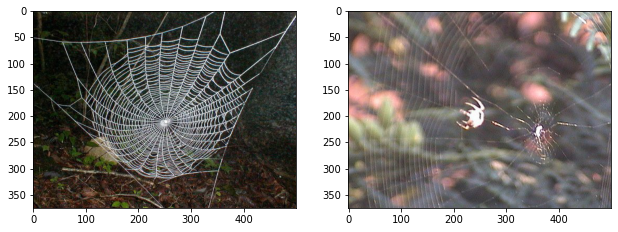

In [12]:
print(f"Image of class type: {class_map[list(train_imgs.keys())[1]]}")
plot_images_grid(3,3,list(train_imgs.values())[1],figsize=(16,16))

In [13]:
transform = torch.nn.Sequential(
    transforms.Resize(config.training.image_size),
    transforms.Normalize(ImageNetMean,ImageNetVariance)
)

In [14]:
# TODO Dataset Reproducability incase training interupts
mini_imagenet_dataset_train = MiniImageNetDataset(config.dataset.train_path,\
    N_way=config.training.N_way,\
        K_shot=config.training.K_shot,\
            query_samples_per_class=config.training.query_samples_per_class, \
                transform= transform, sample_frac = 0.1 )

mini_imagenet_dataset_val = MiniImageNetDataset(config.dataset.val_path,\
    N_way=config.training.N_way,\
        K_shot=config.training.K_shot,\
            query_samples_per_class=config.training.query_samples_per_class, \
                transform= transform, sample_frac = 0.1 )

No of classes in /home/azureuser/cloudfiles/code/Users/asahu.cool/Work/Datasets/MiniImageNet/mini_imagenet_full_size/train are 64
No of classes in /home/azureuser/cloudfiles/code/Users/asahu.cool/Work/Datasets/MiniImageNet/mini_imagenet_full_size/val are 16


In [15]:
train_dl = DataLoader(mini_imagenet_dataset_train,batch_size= config.training.batch_size,shuffle= True)
val_dl = DataLoader(mini_imagenet_dataset_val,batch_size= config.training.batch_size,shuffle= False)

In [16]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = torch.nn.Linear(512,5)

In [17]:
device = 'cpu'
if config.training.gpu:
    if torch.cuda.is_available():
        device = f"cuda:{torch.cuda.current_device()}"
      
resnet18.to(device)
optim = torch.optim.Adam(resnet18.parameters(), lr = config.training.lr)

#TODO Implement cosine annealing
#TODO Implement ckpting
#TODO Implement a trainer class to store info like iterations epochs etc

iteration = 0

for epoch in range(config.training.n_epochs):
        
    do_train(iteration , epoch , device,torch.nn.BCEWithLogitsLoss(),optim,AdamExplicitGrad,\
        resnet18,train_dl,val_dl,config.training.inner_loop_steps)
    
    epoch += 1


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 0/7 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss => 1.133423089981079 with batch size => 16
Epoch: 0 Iteration: 1 Accuracy => 31.25 % with total_preds => 160 


 14%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/7 [00:35<03:33, 35.64s/it]

Epoch: 0 Iteration: 2 Loss => 1.2394428253173828 with batch size => 16
Epoch: 0 Iteration: 2 Accuracy => 24.375 % with total_preds => 160 


 29%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                | 2/7 [01:10<02:54, 34.97s/it]

Epoch: 0 Iteration: 3 Loss => 1.2164875268936157 with batch size => 16
Epoch: 0 Iteration: 3 Accuracy => 34.375 % with total_preds => 160 


 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 3/7 [01:44<02:19, 34.90s/it]

Epoch: 0 Iteration: 4 Loss => 1.1857340335845947 with batch size => 16
Epoch: 0 Iteration: 4 Accuracy => 33.125 % with total_preds => 160 


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                             | 4/7 [02:21<01:46, 35.57s/it]

Epoch: 0 Iteration: 5 Loss => 1.366890788078308 with batch size => 16
Epoch: 0 Iteration: 5 Accuracy => 28.125 % with total_preds => 160 


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 5/7 [02:58<01:11, 35.90s/it]

Epoch: 0 Iteration: 6 Loss => 1.2951624393463135 with batch size => 16
Epoch: 0 Iteration: 6 Accuracy => 24.375 % with total_preds => 160 


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 6/7 [03:34<00:35, 35.98s/it]

Epoch: 0 Iteration: 7 Loss => 1.358609676361084 with batch size => 13
Epoch: 0 Iteration: 7 Accuracy => 24.615384615384617 % with total_preds => 130 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:02<00:00, 34.67s/it]


In [18]:
import gc
gc.collect()
torch.cuda.empty_cache()
(xs,ys), (xq,yq) = next(iter(val_dl)) 
batch_sz, support_sz, C, H, W = xs.shape
outp = resnet18(xs.reshape(-1,C,H,W).cuda())
outp.device, outp.shape

(device(type='cuda', index=0), torch.Size([400, 5]))

In [19]:
_ , y_preds = torch.max(outp,dim=1)

In [20]:
y_preds[:25]

tensor([3, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 4, 3, 0, 1, 3, 2, 2, 3, 0, 2, 0, 2,
        4], device='cuda:0')